In [37]:
!pip install plotly

In [128]:
import pandas as pd 
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from scipy import stats as st
import numpy as np
import math as mth
pd.set_option('display.max_colwidth', -1)
logs = pd.read_csv(r'C:\Users\Nikita\Desktop\Yandex Practicum\logs_exp.csv',delimiter='\t')

logs.info()

C:\Users\Nikita\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## ШАГ 2. Подготовьте данные

In [39]:
#пропусков нет
logs.isnull().sum()

logs.duplicated().sum()

#413 строк задублированы из 244к df , дропну их спокойно

logs = logs.drop_duplicates()

#поменял название столбцов
logs.columns =['event','user_id','event_time','test_group']

#перевел дату и время в необходимый формат 
logs['event_time'] = pd.to_datetime(logs['event_time'],unit= 's')

#выделил отдельно дату
logs['date'] = logs['event_time'].dt.date


logs.head()
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   test_group  243713 non-null  int64         
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


## ШАГ 3. Изучите и проверьте данные

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько всего в среднем событий приходится на пользователя?

In [40]:
print('Сколько всего событий в логе?',len(logs))
print('Сколько всего пользователей в логе?',logs['user_id'].nunique())
print('Сколько всего в среднем событий приходится на пользователя? Среднее арифм.:', round(len(logs)/logs['user_id'].nunique()))
print('Сколько всего в среднем событий приходится на пользователя? Чаще встречаемое:', logs['user_id'].value_counts().mode()[0])

Сколько всего событий в логе? 243713
Сколько всего пользователей в логе? 7551
Сколько всего в среднем событий приходится на пользователя? Среднее арифм.: 32
Сколько всего в среднем событий приходится на пользователя? Чаще встречаемое: 5


- Найдите временые рамки. Постройте гистограмму по дате и времени, полные ли у нас данные и данные за какой период у нас на самом деле?

In [41]:
print('Данные за период с начала {}, по {}'.format(logs['date'].min(),logs['date'].max()))

Данные за период с начала 2019-07-25, по 2019-08-07


In [42]:
#построю график, чтобы оценить за какой период у нас данные
period_data = logs.groupby('date',as_index = False).event_time.count()

graf = go.Bar(
    x = period_data.date,
    y = period_data.event_time
)
layout = go.Layout(
    title='Период данных',
    yaxis_title= 'Количество Логов',
)

fig = go.Figure(data = [graf], layout = layout)
iplot(fig)

Вывод: полные данные у нас есть с 1 августа по 7 августаю. Соответственно 

In [43]:
#выделим новый отфильтрованный df с корректной датой начала периода анализа
corr_date = pd.to_datetime('2019-08-01', format ='%Y-%m-%d')
corr_logs = logs[logs['date'] >= corr_date]

In [44]:
print('Сколько всего было первоначально событий в логе?',len(logs))
print('Сколько всего стало после фильтрации событий в логе?',len(corr_logs))
print('Разница в логах:',len(logs) - len(corr_logs))
print('Сколько всего было первоначально пользователей в логе?',logs['user_id'].nunique())
print('Сколько всего стало после фильтрации пользователей в логе?',corr_logs['user_id'].nunique())
print('Разница в пользователях:',logs['user_id'].nunique() - corr_logs['user_id'].nunique())

Сколько всего было первоначально событий в логе? 243713
Сколько всего стало после фильтрации событий в логе? 240887
Разница в логах: 2826
Сколько всего было первоначально пользователей в логе? 7551
Сколько всего стало после фильтрации пользователей в логе? 7534
Разница в пользователях: 17


In [50]:
#есть логи пользователей всех экспериментальных групп
group_users = corr_logs.groupby('test_group').event.count()
group_users.head()

test_group
246    79302
247    77022
248    84563
Name: event, dtype: int64

## Шаг 4. Изучение воронки событий.

 - Посмотрите какие событие есть в логах, как часто они встречаются. Отсортируйте события по частоте
 - Посчитайте сколько пользователей совершали каждое из этих событий. Посчитайте долю пользователей, которые хоть раз соверашли событие
 - Предположите в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчете воронки.
 - По воронке событий посчитайте какая доля пользователей проходит на след шаг. А>B>C к А
 - На каком этапе теряется большего всего пользователей?
 - Какая доля пользователей доходит от первого события до оплаты?

In [46]:
#посчитаю уник. пользователей
users_events = corr_logs.groupby('event').user_id.nunique()
users_events = users_events.reset_index()
users_events.columns = ['event','uniq_users']

#посчитаю логи
logs_events = corr_logs.groupby('event').user_id.count()
logs_events = logs_events.reset_index()
logs_events.columns = ['event','logs']

#сведу данные
events = pd.merge(users_events,logs_events, on='event')
events = events.sort_values(by='uniq_users',ascending = False)

events['users_proc'] = events['uniq_users'].apply(lambda x: round(x/7419*100,2))


events.head()

,event,uniq_users,logs,users_proc
1,MainScreenAppear,7419,117328,100.00
2,OffersScreenAppear,4593,46333,61.91
0,CartScreenAppear,3734,42303,50.33
3,PaymentScreenSuccessful,3539,33918,47.70
4,Tutorial,840,1005,11.32


Хронология появления событий :

1. MainScreenAppear / появление главного экрана
2. Tutorial / прохождение или прочтение обучающего материала
3. OffersScreenAppear / появление экрана с товаром
4. CartScreenAppear / появление экрана с корзиной
5. PaymentScreenSuccessful / экран успешной оплаты 

Очевидно, что событие туториал лишние , не является обязательным и посути не на что не влияет, даже кол-во значений мало

Построю воронку событий, без учета Туториал

In [47]:
events_funnel = events[events['event'] != 'Tutorial']

fig = go.Figure(go.Funnel(
    y = ["Главный Экран", "Экран Товара", "Корзина", "Покупка завершена"],
    x = events_funnel.uniq_users,
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.85, marker = {"color": ["orange", "tan", "silver", "lightsalmon"],
    "line": {"width": [2, 2, 2, 3], "color": ["black", "black", "black", "red"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.update_layout(
    title={
        'text': "Воронка Пользователей",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

На этапе появления "Экран Товара" проваливаются только 62% пользователей кто видел Главный Экран. Далее намного лучше , в Корзину кладут товар 81% от тех кто видел Экран Товара, а совершают покупку 95% тех кто положил в Корзину. Это круто

Теперь посмотрим, сколько пользователей проходит по всем 4 этапам воронки:

In [48]:
#создам пивот по эвентам, далее буду его применять для определения последовательных пользователей
users_jour = corr_logs.pivot_table(index='user_id',columns='event',values='event_time',aggfunc='min')

#обозначим в переменных какие последовательные события будут характерны для каждого пользователя в стадии
main_users = ~users_jour['MainScreenAppear'].isnull()
offer_users = main_users & (users_jour['OffersScreenAppear'] > users_jour['MainScreenAppear'])
cart_users = offer_users & (users_jour['CartScreenAppear'] > users_jour['OffersScreenAppear'])
purchase_users = cart_users & (users_jour['PaymentScreenSuccessful'] > users_jour['CartScreenAppear'])

#применим пивот и переменную к определению пользователя на каждом последовательном этапе. шейп вернет кол-во 
main_users = users_jour[main_users].shape[0]
offer_users = users_jour[offer_users].shape[0]
cart_users = users_jour[cart_users].shape[0]
purchase_users = users_jour[purchase_users].shape[0]


In [49]:
#построю воронку

fig = go.Figure(go.Funnel(
    y = ["Главный Экран", "Экран Товара", "Корзина", "Покупка завершена"],
    x = [main_users, offer_users, cart_users, purchase_users]))
fig.update_layout(
    title={
        'text': "Последовательная Воронка Пользователей",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Всего 454 пользователя из 7 419 дошли до конца и совершили покупку. Это значит , что многие пользователи начинают свой путь не с Главного Экрана. Как вариант приходят из поиска или контекста, сразу на Экран с товаром.

## Шаг 5. Изучение результатов эксперимента.

In [60]:
#Кол-во пользователей в каждой группе
corr_logs.groupby('test_group').user_id.nunique()

test_group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [134]:
# соберу таблицу с информацией по каждой группе 

group_users = corr_logs.pivot_table(index='test_group',columns='event',values='user_id',aggfunc='nunique').reset_index()

#добавлю еще уник. пользователей 
users_uniq = corr_logs.groupby('test_group').user_id.nunique()

group_users['users_uniq'] = group_users['test_group'].apply(lambda x: users_uniq.loc[x])

#нужно сделать индексом столбец тест.группа, чтобы можно было легко добавить новый ряд 246+247
group_users = group_users.set_index('test_group')

#еще нужно добавить объединенную группк 246+247

row = group_users.loc[246] + group_users.loc[247]

row.name = '246_247'

group_users = group_users.append([row])

#вернулся сюда, что бы переделать индекс, для дальнейшего расчетов АВ теста, буду брать 3 строки
group_users = group_users.reindex([246, 247, '246_247', 248])

group_users

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,users_uniq
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
246_247,2504,4926,3062,2358,561,4997
248,1230,2493,1531,1181,279,2537


In [69]:
# согласно учебному материалу мы будет проверять гипотезы о равенстве долей Z тестом, лучше написать функцию расчета Z теста 
# так как мы ее будем применять далее везде 

def z_test(part0, part1, total0, total1):  
    
    alpha = .05  #критический уровень статистической значимости
    p1 = part0 / total0 #пропорция успехов в первой группе
    p2 = part1 / total1 #пропорция успехов во второй группе
    p_combined = (part0 + part1) / (total0 + total1) # пропорция успехов в комбинированном датасете
    difference = p1 - p2 #разница пропорций в датасетах
    
    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    
    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    return p_value

- АА тест нужно проверит есть ли статистические критерии разницы меду Выборками 246 и 247.И проверить нужно по всем событиям


In [130]:
#нужно создать датафрейм для будущих расчетов

AA_test = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

#опции вариантов результата теста 
test_options = ["Отвергаем нулевую гипотезу - между группам есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"]
#группа теста
group_1 = 246
current_row = group_users.loc[group_1]
group_2 = 247
#цикл для расчета pvalue для каждого события внутри группы
for event in range(4):
    curr_event = group_users.columns[event]
    p_value = z_test(current_row[curr_event],
                            group_users[curr_event][group_2],
                            current_row['users_uniq'],group_users['users_uniq'][group_2]
                    )
    #этим рядом мы наполняем наш созданный выше датафрейм
    new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': group_users.columns[event],
               'p_alpha': 0.05,
               'p_value': round(p_value, 3),
               'Результат': test_options[p_value >= 0.05]}
    AA_test = AA_test.append([new_row])

AA_test.index = range(len(AA_test))       

AA_test

C:\Users\Nikita\anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,247,CartScreenAppear,0.05,0.229,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
1,246,247,MainScreenAppear,0.05,0.757,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
2,246,247,OffersScreenAppear,0.05,0.248,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
3,246,247,PaymentScreenSuccessful,0.05,0.115,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"


Между группами 246 и 247 статистически значимых различий нет, тест АА провед корректно. Переходим к АВ тесту

Получается, что нужно сравнить в АВ тесте следующее:

A(246) vs B(248);
A(247) vs B(248);
A(246+247) vs B(248);


In [135]:
#нужно создать датафрейм для будущих расчетов

AB_test = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

#опции вариантов результата теста 
test_options = ["Отвергаем нулевую гипотезу - между группам есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"]

#нужно модернизировать цикл, так как тестовых групп у нас 3 :
#x бегаеи по df group_users и берет значение группы в идексе , кроме группы 248
for x in range(3):
    group_1 = group_users.index[x]
    current_row = group_users.loc[group_1]
    group_2 = 248


#цикл для расчета pvalue для каждого события внутри группы
    for event in range(4):
        curr_event = group_users.columns[event]
        p_value = z_test(current_row[curr_event],
                            group_users[curr_event][group_2],
                            current_row['users_uniq'],group_users['users_uniq'][group_2]
                    )
    #этим рядом мы наполняем наш созданный выше датафрейм
        new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': group_users.columns[event],
               'p_alpha': 0.05,
               'p_value': round(p_value, 3),
               'Результат': test_options[p_value >= 0.05]}
        AB_test = AB_test.append([new_row])

AB_test.index = range(len(AB_test))       

AB_test

C:\Users\Nikita\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,248,CartScreenAppear,0.05,0.078,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
1,246,248,MainScreenAppear,0.05,0.295,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
2,246,248,OffersScreenAppear,0.05,0.208,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
3,246,248,PaymentScreenSuccessful,0.05,0.212,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
4,247,248,CartScreenAppear,0.05,0.579,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
5,247,248,MainScreenAppear,0.05,0.459,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
6,247,248,OffersScreenAppear,0.05,0.920,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
7,247,248,PaymentScreenSuccessful,0.05,0.737,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
8,246_247,248,CartScreenAppear,0.05,0.182,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"
9,246_247,248,MainScreenAppear,0.05,0.294,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными"


АВ тест показал что нет значимых статистических отличий между группами по каждому событию.

Уровень значимости использовался стандартный 0,05. У нас было 4 проверки гипотез по сути, на тех же данных
У нас получается что с каждой новой проверкой гипотезы растет вероятность ошибки первого рода. Соответственно, мы могли бы использовать  множественную поправку для уменьшения значения значимости (а). Например, популярную поправку Бонферрони :

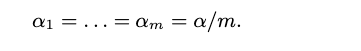


Поделив уровень значимости на кол-во проверенных гипотез (4). Но смысла в этом я не вижу, так как при текущем уровне значимости значение p-value выше в каждом событие , при каждом сценарии теста

Вывод:

Статистически значимых различий в тесте АА обнаружено не было, это значит , что пользователи относятся к каждой группе корректно.

Также нет статистически значимых различий в тесте АВ.
Это значит , что изменение шрифта на главной странице не влияет на конверисю 


Возможно, причина резьтата такого АВ теста в том, что данные всего за 1 неделю,возможно за больший период картина поменяется.
Но возможно и нет, так как значения p_value мы получили достаточно высокие 